In [77]:
import itertools
import operator
import sys
import os
from collections import defaultdict
import numpy as np
sys.path.append("../src")
from glob import glob
import pandas as pd
import json
from matplotlib import pyplot as plt

In [96]:
search_root = "/checkpoint/jth/job_staging/neuraldb_expts/experiment=oracle_fusion"
checkpoint_name = "metrics_test.json"
files = glob("{}*/**/{}".format(search_root,checkpoint_name), recursive=True)

search_root = "/checkpoint/jth/neuraldb/experiment=oracle_large/"
checkpoint_name = "metrics_test.json"
files.extend(glob("{}*/**/{}".format(search_root,checkpoint_name), recursive=True))


print(len(files))

24


In [141]:
def expand(idx,chunk):

  #elif idx == 1:
  #  return ["experiment={}".format(chunk)]
  if chunk.startswith("seed-"):
    return ["seed={}".format(chunk.replace("seed-",""))]
  elif "," in chunk:
    return chunk.split(",")
  elif "=" in chunk:
    return [chunk]
  return []

experiments = []
for file in files:
    chunks = file.replace(search_root,"").split("/")
    chunks = itertools.chain(*[expand(idx, chunk) for idx, chunk in enumerate(chunks)])

    data = {k:v for k,v in (chunk.split("=") for chunk in chunks)}
    data["file"] = file
    data["context"] = int(data["context"])
    data['dir'] = os.path.dirname(file)
    data["filter_size"] = int(data["filter_size"]) if "filter_size" in data else None

    if data["filter_size"] is None:
        print(data["file"])
    if "5" not in data["lr"]:
        continue

    data["lr"] = float(data["lr"])

    if data["context"] != 50:
        continue


    if data["version"] == "v0.4" or data["version"] == "v0.5":
        experiments.append(data)



/checkpoint/jth/neuraldb/experiment=oracle_large/dataset=ndb,model=t5-base,oracle=true,version=v0.5/lr=5e-4/context=50,filters=null,max_queries=null/seed-1/metrics_test.json
/checkpoint/jth/neuraldb/experiment=oracle_large/dataset=ndb,model=t5-base,oracle=true,version=v0.5/lr=5e-4/context=50,filters=null,max_queries=null/seed-3/metrics_test.json
/checkpoint/jth/neuraldb/experiment=oracle_large/dataset=ndb,model=t5-base,oracle=true,version=v0.5/lr=5e-4/context=50,filters=null,max_queries=null/seed-4/metrics_test.json
/checkpoint/jth/neuraldb/experiment=oracle_large/dataset=ndb,model=t5-base,oracle=true,version=v0.5/lr=5e-4/context=50,filters=null,max_queries=null/seed-2/metrics_test.json


In [142]:
for experiment in experiments:
    print(experiment["file"])
    if "v0.4" in experiment["file"]:
        continue
        with open(experiment['file']) as f:
            results = json.load(f)

        experiment["EM"] = results['test']["EM"]

        for k,v in results['test']["raw"]["relation_type"].items():
            experiment["breakdown_{}".format(k)] = np.mean(v)


        for k,v in results['test']["raw"]["query_type"].items():
            if k == "list":
                k = "set"

            if k == "min_max":
                k = "min/max"

            if k == "agg":
                k = "count"


            if k == "atomic":
                experiment["type_atomic_boolean"] = np.mean(v)
                experiment["type_atomic_extractive"] = np.mean(v)
            elif k == "join":
                experiment["type_join_boolean"] = np.mean(v)
                experiment["type_join_extractive"] = np.mean(v)
            else:
                experiment["type_{}".format(k)] = np.mean(v)


    elif "v0.5" in experiment["file"] and True: #and "fusion" not in experiment["file"]:

        all_raw = []
        all_breakdown = defaultdict(dict)
        all_breakdown_strict = defaultdict(dict)

        with open(experiment['file']) as f:
            for line in f.readlines()[-4:]:
                if line[0] == "}":
                    line = line[1:]
                try:
                    partial_results = json.loads(line)

                except Exception as e:

                    continue

                all_raw.extend(partial_results['test']['raw'])
                all_breakdown["breakdown_prop"].update(partial_results['test']['breakdown']["relation_type"].items())
                all_breakdown["breakdown_type"].update(partial_results['test']['breakdown']["query_type"].items())

                all_breakdown_strict["breakdown_prop"].update(partial_results['test']['strict_breakdown']["relation_type"].items())
                all_breakdown_strict["breakdown_type"].update(partial_results['test']['strict_breakdown']["query_type"].items())

        experiment["EM"] = np.mean([rec[2] for rec in all_raw])


        experiment["EM_strict"] = np.mean([rec[3] for rec in all_raw])

        for k,v in all_breakdown["breakdown_type"].items():

            experiment["type_{}".format(k)] = np.mean(v)
            experiment["count_type_{}".format(k)] = len(v)

        for k,v in all_breakdown_strict["breakdown_type"].items():
            experiment["type_strict_{}".format(k)] = np.mean(v)


    elif "v0.5" in experiment["file"] and "fusion" in experiment["file"]:
        print("v5")
        all_raw = []
        all_breakdown = defaultdict(dict)
        all_breakdown_strict = defaultdict(dict)

        with open(experiment['file']) as f:
            partial_results = json.load(f)

            all_raw.append(partial_results['test']['EM'])
            all_breakdown["breakdown_prop"].update(partial_results['test']['raw']["relation_type"].items())
            all_breakdown["breakdown_type"].update(partial_results['test']['raw']["query_type"].items())

        experiment["EM"] = np.mean([rec for rec in all_raw])


        for k,v in all_breakdown["breakdown_type"].items():

            if k == "list":
                k = "set"

            if k == "min_max":
                k = "min/max"

            if k == "agg":
                k = "count"


            if k == "atomic":
                experiment["type_atomic_boolean"] = np.mean(v)
                experiment["type_atomic_extractive"] = np.mean(v)
            elif k == "join":
                experiment["type_join_boolean"] = np.mean(v)
                experiment["type_join_extractive"] = np.mean(v)
            else:
                experiment["type_{}".format(k)] = np.mean(v)

            experiment["type_{}".format(k)] = np.mean(v)
            experiment["count_type_{}".format(k)] = len(v)


/checkpoint/jth/job_staging/neuraldb_expts/experiment=oracle_fusion/dataset=ndb,model=t5-base,retrieval=oracle,version=v0.5/lr=0.0005,filter_size=12/context=50/seed-1/metrics_test.json
/checkpoint/jth/job_staging/neuraldb_expts/experiment=oracle_fusion/dataset=ndb,model=t5-base,retrieval=oracle,version=v0.5/lr=0.0005,filter_size=12/context=50/seed-2/metrics_test.json
/checkpoint/jth/job_staging/neuraldb_expts/experiment=oracle_fusion/dataset=ndb,model=t5-base,retrieval=oracle,version=v0.5/lr=0.0005,filter_size=12/context=50/seed-4/metrics_test.json
/checkpoint/jth/job_staging/neuraldb_expts/experiment=oracle_fusion/dataset=ndb,model=t5-base,retrieval=oracle,version=v0.5/lr=0.0005,filter_size=12/context=50/seed-5/metrics_test.json
/checkpoint/jth/job_staging/neuraldb_expts/experiment=oracle_fusion/dataset=ndb,model=t5-base,retrieval=oracle,version=v0.5/lr=0.0005,filter_size=12/context=50/seed-3/metrics_test.json
/checkpoint/jth/neuraldb/experiment=oracle_large/dataset=ndb,model=t5-base,

In [143]:
results = pd.DataFrame(experiments).fillna(0)
cols = {col:[np.mean, np.std] for col in filter(lambda col: col == "EM" or col.startswith("type_"),results.columns)}

query_cols = list(filter(lambda col: col.startswith("query_"),results.columns))
print(query_cols)
breakdown_cols = list(filter(lambda col: col.startswith("breakdown_"),results.columns))
breakdown = pd.pivot_table(results, index=["context","filter_size"],columns=[], aggfunc=cols)
breakdown



[]


EM           type_atomic_boolean            \
                         mean       std                mean       std   
context filter_size                                                     
50      0.0          0.953912  0.001718            0.993687  0.002525   
        12.0         0.747124  0.003401            0.987886  0.002020   

                    type_atomic_extractive           type_count            \
                                      mean       std       mean       std   
context filter_size                                                         
50      0.0                       0.989346  0.002612   0.765330  0.011792   
        12.0                      0.915198  0.004560   0.280102  0.006603   

                    type_join_boolean            ... type_strict_count  \
                                 mean       std  ...              mean   
context filter_size                              ...                     
50      0.0                  0.996951  0.006098  ...          0.765330   
        12.0                 0.575000  0.002541  ...          0.280102   

                              type_strict_join_boolean            \
                          std                     mean       std   
context filter_size                                                
50      0.0          0.011792                 0.996951  0.006098   
        12.0         0.006603                 0.575000  0.002541   

                    type_strict_join_extractive           type_strict_min/max  \
                                           mean       std                mean   
context filter_size                                                             
50      0.0                            1.000000  0.000000            0.947368   
        12.0                           0.266667  0.027263            0.057143   

                              type_strict_set            
                          std            mean       std  
context filter_size                                      
50      0.0          0.042974        0.960898  0.002468  
        12.0         0.015475        0.441812  0.022554  

[2 rows x 30 columns]

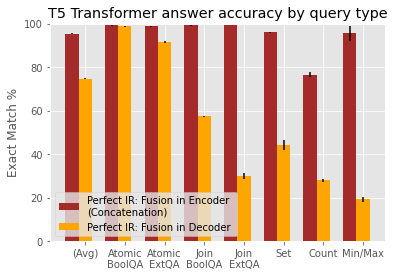

In [148]:
models = set(idx[0] for idx in breakdown.index)
lookup = {
    "EM":"(Avg)",
    "type_set":"Set",
          "type_count": "Count",
          "type_min/max": "Min/Max",
          "type_join_boolean": "Join\nBoolQA",
          "type_join_extractive": "Join\nExtQA",
          "type_atomic_boolean": "Atomic\nBoolQA",
          "type_atomic_extractive":"Atomic\nExtQA"}

lookup2 = {
    0:"Perfect IR: Fusion in Encoder \n(Concatenation)",
    12:"Perfect IR: Fusion in Decoder"

}


def doplot(filters,count, cols=query_cols):
    means = []
    std = []

    for col in cols:
        means.append(breakdown[col]["mean"].T["t5-base"][count][filters])
        std.append(breakdown[col]["std"].T["t5-base"][count][filters])

    plt.figure(figsize=(5,4))
    plt.xticks(rotation=90)


    plt.title(f"Scores for queries over database with {count} facts {filters}")
    plt.xlabel("Query Type")
    plt.ylabel("Exact Match %")
    plt.ylim(0,1)
    plt.bar([lookup[col] if col in lookup else col for col in cols], means, yerr=std)
    plt.tight_layout()

    return plt

def doplot_cmp(filters, count, cols=query_cols):
    x = np.arange(len(cols))
    w = 1/(len(filters)+1)
    plt.xticks(x+w, [lookup[col] if col in lookup else col for col in cols],rotation=0)
    plt.ylabel("Exact Match %")
    colors = ["brown","orange", "gold", "khaki"]
    for idx, filt in enumerate(filters):
        means = []
        std = []
        for col in cols:

            means.append(breakdown[col]["mean"].T[count][filt]*100)
            std.append(breakdown[col]["std"].T[count][filt]*100)


        plt.bar(x+idx*w,means,yerr=std, width=w, color=colors[idx])

    plt.ylim(0,100)
    plt.legend([lookup2[m] for m in filters], loc='lower left', )# bbox_to_anchor=(1,-0.6))

    return plt

import matplotlib.pyplot as plt
with plt.style.context("ggplot"):
    # plt = doplot("oracle_concat",50, ["EM","query_atomic_boolean",
    #                                   "query_atomic_extractive",
    #                                   "query_join_boolean",
    #                                   "query_join_extractive",
    #                                   "query_set",
    #                                   "query_count",
    #                                   "query_min/max"
    #                                   ])

    plt = doplot_cmp([0,12],50, ["EM","type_atomic_boolean",
                                  "type_atomic_extractive",
                                  "type_join_boolean",
                                  "type_join_extractive",
                                  "type_set",
                                  "type_count",
                                  "type_min/max"
                                  ])

    plt.title("T5 Transformer answer accuracy by query type")

    plt.savefig("/scratch/jth/neuraldb/t5_fid.pdf")
    plt.show()





In [83]:
ds_sizes = [50,100,500,1000,2000,5000,7000,10000]
for col in query_cols:
    means = [breakdown[col]["mean"].T["t5-base"][ds]["v0.4"] for ds in ds_sizes]
    std = [breakdown[col]["std"].T["t5-base"][ds]["v0.4"] for ds in ds_sizes]
    plt.figure(figsize=(16,4))
    plt.xticks(rotation=0)
    plt.xscale("log")

    plt.title("Scores for queries over relation `{}` without training on relations".format(col.replace("breakdown_","")))
    plt.xlabel("Database size")
    plt.ylabel("Exact Match %")
    plt.plot(ds_sizes, means)
    #plt.fill_between(range(len(std)), [m-s for m,s in zip(means, std)],[m+s for m,s in zip(means, std)],alpha=0.1)
    plt.show()

In [84]:
ds = 500
col = "query_atomic"
means = breakdown[col]["mean"].T["t5-base"][ds]["v0.5"]
std = breakdown[col]["std"].T["t5-base"][ds]["v0.5"]
plt.figure(figsize=(16,4))
plt.xticks(rotation=0)


plt.title("Scores for queries over relation `{}` without training on relations".format(col.replace("breakdown_","")))
plt.xlabel("Max number of updates to be used")
plt.ylabel("Exact Match %")
plt.plot(means)
plt.fill_between(means.index, [m-s for m,s in zip(means, std)],[m+s for m,s in zip(means, std)],alpha=0.1)
plt.show()



KeyError: 'query_atomic'

In [ ]:
means = []
std = []
rs =10000
for col in breakdown_cols:
    means.append(breakdown[col]["mean"].T["t5-base"][rs]["v0.4"][8])
    std.append(breakdown[col]["std"].T["t5-base"][rs]["v0.4"][8])

plt.figure(figsize=(16,4))
plt.xticks(rotation=90)

plt.title("Scores for queries over relations")
plt.xlabel("Relation name")
plt.ylabel("Exact Match %")

plt.bar(breakdown_cols, means, yerr=std)
plt.show()


means = []
std = []

for col in query_cols:
    means.append(breakdown[col]["mean"].T["t5-base"][rs]["v0.4"][8])
    std.append(breakdown[col]["std"].T["t5-base"][rs]["v0.4"][8])

plt.figure(figsize=(16,4))
plt.xticks(rotation=90)
plt.ylim(0,1)

plt.title("Scores for queries over database with {} facts".format(rs))
plt.xlabel("Relation name")
plt.ylabel("Exact Match %")

plt.bar(query_cols, means, yerr=std)
plt.show()